In [1]:
#| default_exp workflow


🧬 Setting up initial population and configuration...
   - Founder population created with Mean TBV: 100.00

🚀 Preparing & running 5 replicates in parallel for 20 cycles each...
   - Simulation complete.

🔎 Analyzing results (phenotypic selection).
   - Mean TBV of final generation for each replicate:
     - Replicate 1: Initial TBV = 100.00 -> Final TBV = 120.01
     - Replicate 2: Initial TBV = 100.00 -> Final TBV = 117.45
     - Replicate 3: Initial TBV = 100.00 -> Final TBV = 119.96
     - Replicate 4: Initial TBV = 100.00 -> Final TBV = 118.29
     - Replicate 5: Initial TBV = 100.00 -> Final TBV = 117.10

   - Average Final TBV across all replicates: 118.56
   - Average final selection score (phenotype mean): 118.80


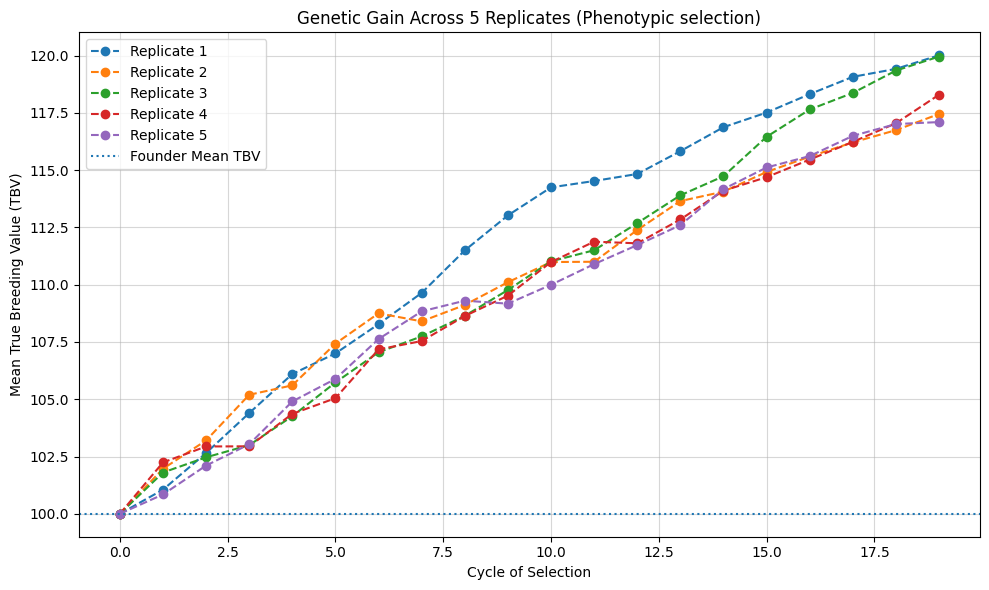


✅ Script finished successfully.


In [2]:
#|export

# ===============================
# MAIN EXPERIMENT (Phenotypic selection only)
# ===============================
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import lax, vmap
from functools import partial

# Local module imports (adjust to your package name if needed)
from chewc.config import StaticConfig, DynamicConfig
from chewc.popgen import create_founders
from chewc.trait import add_trait, set_pheno_h2
from chewc.meiosis import create_offspring

# ===============================
# 5) ONE GENERATION STEP (phenotypic selection)
# ===============================
def generation_step(carry, gen_idx: int, s_config: StaticConfig, h2: float):
    current_pop, key, d_config, next_id = carry

    # keys: keep streams independent
    key, pheno_key, mate_key, cross_key = jax.random.split(key, 4)
    mate_key_m, mate_key_f = jax.random.split(mate_key)

    # Phenotype generation at target h2 (single trait assumed)
    pheno, bv, gv, genetic_variance_vec, var_e_vec = set_pheno_h2(
        pheno_key,
        current_pop,
        d_config,
        h2,
        n_loci_per_chr=s_config.n_loci_per_chr,
        trait_index=0,
        broad_sense=False,
    )
    # convenience: single-trait vectors
    y   = pheno.squeeze(-1)  # (N,)
    tbv = bv.squeeze(-1)     # (N,)

    # selection scores = phenotype (phenotypic selection)
    scores = y

    # choose top parents
    top_parent_indices = jnp.argsort(scores)[-s_config.n_select:]
    selected_parents_pop = jax.tree_util.tree_map(lambda x: x[top_parent_indices], current_pop)

    # random mating within selected set (avoid selfing)
    parent_pool_indices = jnp.arange(s_config.n_select)
    mothers = jax.random.choice(mate_key_m, parent_pool_indices, (s_config.n_offspring,))
    fathers = jax.random.choice(mate_key_f, parent_pool_indices, (s_config.n_offspring,))
    fathers = jnp.where(mothers == fathers, (fathers + 1) % s_config.n_select, fathers)
    pairings = jnp.stack([mothers, fathers], axis=1)

    offspring_pop = create_offspring(
        cross_key, selected_parents_pop, pairings,
        s_config, d_config, current_gen=gen_idx + 1, next_id_start=next_id
    )

    new_next_id = next_id + s_config.n_offspring
    history_row = {
        "mean_tbv":   jnp.mean(tbv),
        "mean_pheno": jnp.mean(y),
        "mean_score": jnp.mean(scores),  # == mean_pheno under phenotypic selection
    }
    return (offspring_pop, key, d_config, new_next_id), history_row


# ===============================
# 6) SIM DRIVER
# ===============================
@partial(jax.jit, static_argnames=("s_config", "n_cycles"))
def run_simulation(
    initial_pop,
    initial_key: jax.random.PRNGKey,
    s_config: StaticConfig,
    d_config: DynamicConfig,
    n_cycles: int,
    h2: float,
):
    scan_body = lambda carry, gen_idx: generation_step(
        carry, gen_idx, s_config=s_config, h2=h2
    )
    # next_id starts after founders
    next_id0 = int(initial_pop.geno.shape[0])
    initial_carry = (initial_pop, initial_key, d_config, next_id0)
    (final_pop, _, _, _), history = lax.scan(scan_body, initial_carry, jnp.arange(n_cycles))
    return final_pop, history


# ===============================
# 7) MAIN EXPERIMENT SCRIPT
# ===============================
if __name__ == "__main__":
    print("\n🧬 Setting up initial population and configuration...")
    master_key = jax.random.PRNGKey(42)

    # Independent key streams (avoid reuse)
    master_key, founders_key, trait_key, sims_key = jax.random.split(master_key, 4)

    # Experiment knobs
    n_founders   = 50
    n_replicates = 5
    n_cycles     = 20
    h2           = 0.2  # target heritability

    s_config = StaticConfig(n_chr=10, n_loci_per_chr=100, ploidy=2, n_select=20, n_offspring=50)

    genetic_map     = jnp.full((s_config.n_chr, s_config.n_loci_per_chr), 0.01)
    locus_positions = jnp.cumsum(genetic_map, axis=-1)
    d_config        = DynamicConfig(genetic_map=genetic_map, traits=tuple(), locus_positions=locus_positions)

    founder_pop = create_founders(founders_key, s_config, n_founders)

    # one trait with target mean/var
    final_d_config = add_trait(
        trait_key,
        founder_pop,
        s_config,
        d_config,
        n_qtl_per_chr=10,
        mean=jnp.array([100.0], dtype=jnp.float32),
        var=jnp.array([10.0],  dtype=jnp.float32),
        Sigma=None,
    )

    # compute initial mean TBV
    trait = final_d_config.traits[0]
    founder_dosage = jnp.sum(founder_pop.geno, axis=2).astype(jnp.float32)
    initial_tbv = (
        founder_dosage[:, trait.qtl_chromosome, trait.qtl_position] @ trait.qtl_effects
        + trait.intercept
    ).squeeze()
    initial_tbv_mean = jnp.mean(initial_tbv)

    print(f"   - Founder population created with Mean TBV: {float(initial_tbv_mean):.2f}")

    print(f"\n🚀 Preparing & running {n_replicates} replicates in parallel for {n_cycles} cycles each...")

    # One independent key per replicate (fold_in is robust under vmap)
    replicate_keys = jax.vmap(lambda i: jax.random.fold_in(sims_key, i))(jnp.arange(n_replicates))

    sim_partial = partial(run_simulation, n_cycles=n_cycles, h2=h2)
    vmapped_simulation = vmap(sim_partial, in_axes=(None, 0, None, None))

    final_pops, history = vmapped_simulation(founder_pop, replicate_keys, s_config, final_d_config)

    print("   - Simulation complete.")
    print("\n🔎 Analyzing results (phenotypic selection).")

    # history fields are arrays over cycles; take last
    final_tbvs   = history["mean_tbv"][:, -1]
    final_scores = history["mean_score"][:, -1]

    print("   - Mean TBV of final generation for each replicate:")
    for i in range(n_replicates):
        print(
            f"     - Replicate {i+1}: "
            f"Initial TBV = {float(initial_tbv_mean):.2f} -> Final TBV = {float(final_tbvs[i]):.2f}"
        )

    print(f"\n   - Average Final TBV across all replicates: {float(jnp.mean(final_tbvs)):.2f}")
    print(f"   - Average final selection score (phenotype mean): {float(jnp.mean(final_scores)):.2f}")

    # Plot genetic gain per replicate
    plt.figure(figsize=(10, 6))
    for i in range(n_replicates):
        plt.plot(np.array(history["mean_tbv"][i]), marker="o", linestyle="--", label=f"Replicate {i+1}")
    plt.axhline(float(initial_tbv_mean), linestyle=":", label="Founder Mean TBV")
    plt.title(f"Genetic Gain Across {n_replicates} Replicates (Phenotypic selection)")
    plt.xlabel("Cycle of Selection")
    plt.ylabel("Mean True Breeding Value (TBV)")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n✅ Script finished successfully.")


In [3]:
#| hide
import nbdev; nbdev.nbdev_export()